## Import Dataset

In [1]:
import pandas as pd
import numpy as np
housing_train = pd.read_csv('../datasets/house-prices-advanced-regression-techniques/train.csv')
housing_test = pd.read_csv('../datasets/house-prices-advanced-regression-techniques/test.csv')

In [2]:
housing_train_target = housing_train['SalePrice'].astype(np.float32)
housing_train_features = housing_train.drop('SalePrice', axis=1)

In [3]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
columns_to_drop = ['Alley','PoolQC','MiscFeature','Fence']
categorical_columns = ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities', 'BedroomAbvGr',
                       'LotConfig','Foundation','LandSlope','Neighborhood','Condition1','Condition2','BldgType',
                       'HouseStyle','OverallQual','OverallCond','YearBuilt','YearRemodAdd','RoofStyle',
                       'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','BsmtQual',
                       'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir',
                       'Electrical','KitchenQual','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','Functional',
                       'FireplaceQu','GarageCars','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond',
                       'PavedDrive','MoSold','YrSold','SaleType','SaleCondition','KitchenAbvGr','Fireplaces','TotRmsAbvGrd']
numerical_columns = [col for col in housing_train_features.columns if col != 'Id' and col not in  categorical_columns and col not in columns_to_drop]

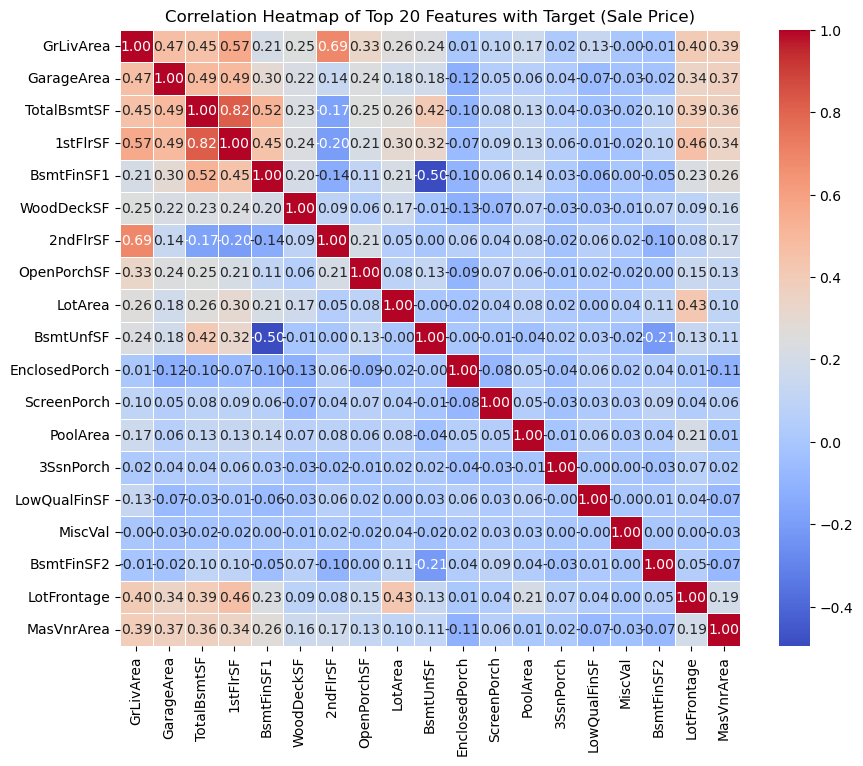

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

Y = housing_train_target.to_numpy().astype(np.float32)

correlation_values = housing_train[numerical_columns].apply(lambda feature: np.abs(np.corrcoef(feature.astype(np.float32), Y)[0, 1]))
sorted_features = correlation_values.sort_values(ascending=False)

# select the top 10 features with the highest correlation
k = 20
corr_features = sorted_features.index[:k]

plt.figure(figsize=(10, 8))
sns.heatmap(housing_train[corr_features].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Top 20 Features with Target (Sale Price)')
plt.show()

In [6]:
selected_features = sorted_features.where(lambda a: a >= 0.20).dropna().index
selected_features

Index(['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1',
       'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF'],
      dtype='object')

In [32]:
fig, axes = plt.subplots(len(selected_features), 2, figsize=(64, 150))
for i in range(0, len(selected_features)):
    sns.kdeplot(ax=axes[i,0],data=housing_train, x=selected_features[i], fill=True)
    sns.kdeplot(ax=axes[i,1],data=housing_train[selected_features[i]].apply(lambda x: np.log(x)), fill=True)

/tmp/ipykernel_79462/2954955108.py:4: RuntimeWarning: divide by zero encountered in log
  sns.kdeplot(ax=axes[i,1],data=housing_train[selected_features[i]].apply(lambda x: np.log(x)), fill=True)
/tmp/ipykernel_79462/2954955108.py:4: RuntimeWarning: divide by zero encountered in log
  sns.kdeplot(ax=axes[i,1],data=housing_train[selected_features[i]].apply(lambda x: np.log(x)), fill=True)
/tmp/ipykernel_79462/2954955108.py:4: RuntimeWarning: divide by zero encountered in log
  sns.kdeplot(ax=axes[i,1],data=housing_train[selected_features[i]].apply(lambda x: np.log(x)), fill=True)
/tmp/ipykernel_79462/2954955108.py:4: RuntimeWarning: divide by zero encountered in log
  sns.kdeplot(ax=axes[i,1],data=housing_train[selected_features[i]].apply(lambda x: np.log(x)), fill=True)
/tmp/ipykernel_79462/2954955108.py:4: RuntimeWarning: divide by zero encountered in log
  sns.kdeplot(ax=axes[i,1],data=housing_train[selected_features[i]].apply(lambda x: np.log(x)), fill=True)
/tmp/ipykernel_79462/2954

# Preprocess data

In [33]:
from sklearn.pipeline import Pipeline, FunctionTransformer, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

def set_index(X, index_column):
    X = X.copy()  # Avoid SettingWithCopyWarning
    X.set_index(index_column, inplace=True)
    return X

def drop_columns(X, columns):
    return X.drop(columns=columns)

def impute_numerical_columns(X, columns):
    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(X[columns])
    return X

def scale_numerical_columns(X, columns):
    scaler = StandardScaler
    X = scaler.fit_transform(X[columns])
    return X


# Column transformer for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Normalize (standardize) the values
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical variables
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, selected_features),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Function to convert data type to float32
def to_float32(X):
    return X.astype(np.float32)

# Transformer to convert data type
dtype_transformer = FunctionTransformer(to_float32)

pipeline = Pipeline(
    steps=[
        ('drop_columns', FunctionTransformer(drop_columns, kw_args={'columns': columns_to_drop})),
        ('set_index', FunctionTransformer(set_index, kw_args={'index_column': 'Id'})),
        ('preprocessor', preprocessor),
        ('to_float32', dtype_transformer)  # Convert to float32
    ]
)

## Training

#### Standardise the target value

In [34]:
target = housing_train_target.astype(np.float32).to_numpy()
mean_val = np.mean(target)
std_dev = np.std(target)
standardized_target = (target - mean_val) / std_dev

print("Original Target Values:", target)
print("Standardized Target Values:", standardized_target)

Original Target Values: [208500. 181500. 223500. ... 266500. 142125. 147500.]
Standardized Target Values: [ 0.34727335  0.00728843  0.53615385 ...  1.0776113  -0.48852292
 -0.4208407 ]


#### Transform dataset for training a basic neural network

In [11]:
from sklearn.model_selection import train_test_split
housing_clean_x_np = housing_train_transformed_new.to_numpy()
housing_clean_y_np = standardized_target
X_train, X_test, y_train, y_test = train_test_split(housing_clean_x_np, housing_clean_y_np, test_size=0.2, random_state=35)
y_train = np.expand_dims(y_train, axis=0)
y_test = np.expand_dims(y_test, axis=0)

In [ ]:
import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_train.shape[1]

#### Define and train the neural network

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Step 2: Define the Model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.sigmoid(self.layer4(x))
        return x

model = NeuralNetwork()

# Step 3: Define the Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the Model
num_epochs = 130
batch_size = 256

for epoch in range(num_epochs):
    model.train()
    
    # Shuffle the data at the beginning of each epoch
    perm = torch.randperm(X_train.size(0))
    X_train = X_train[perm]
    y_train = y_train.flatten()[perm]
    
    for i in range(0, X_train.size(0), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 5: Evaluate the Model
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Step 6: Make Predictions
predictions = model(X_test)
print(predictions)

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
tree_reg = make_pipeline(pipeline, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing_train, standardized_target)
predicitons_tree_reg = tree_reg.predict(housing_train)

forest_reg = make_pipeline(pipeline, RandomForestRegressor(random_state=42))
forest_reg.fit(housing_train, standardized_target)
predicitons_forest_reg = forest_reg.predict(housing_train)

In [36]:
from sklearn.model_selection import cross_val_score

#tree_rmses = -cross_val_score(tree_reg, housing_train, housing_train_target, scoring='neg_root_mean_squared_error', cv=10)
#pd.Series(tree_rmses).describe()

forest_rmses = -cross_val_score(forest_reg, housing_train, housing_train_target, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     29620.633782
std       7656.137950
min      22866.241048
25%      23702.841790
50%      26433.851182
75%      34522.804912
max      44901.254904
dtype: float64

In [37]:
predicitons_forest_reg = forest_reg.predict(housing_test)
denormalized_predictions_test = predicitons_forest_reg * std_dev + mean_val
housing_test['SalePrice'] = denormalized_predictions_test

In [ ]:
predicitons_tree_reg = tree_reg.predict(housing_test)
denormalized_predictions_test = predicitons_tree_reg * std_dev + mean_val
housing_test['SalePrice'] = denormalized_predictions_test

In [38]:
housing_test[['Id','SalePrice']].reset_index().to_csv('../datasets/house-prices-advanced-regression-techniques/preds_1.csv')

#### Get Predictions

In [ ]:
test_data = housing_test_transformed[selected_features].to_numpy()
test_sub = torch.tensor(test_data, dtype=torch.float32)
predictions_test = model(test_sub)
denormalized_predictions_test = predictions_test * std_dev + mean_val
housing_test['SalePrice'] = denormalized_predictions_test.flatten().detach().numpy()
housing_test[['Id','SalePrice']].reset_index().to_csv('../datasets/house-prices-advanced-regression-techniques/preds.csv')